SSAM
--

**Plots a spectrogram of single component of seismic (or acoustic) data from a file on disk. Spectrogram data are *not* stored following plotting.**

* Data need to be located on a local disk.
* Data are decimated to 50 sps, giving a maximum displayed frequency of 25 Hz.
* Data windows do not overlap.
* Data window length is 3 minutes.
* Frequency resolution is 0.1 Hz. Each FFT is resampled to achieve this.
* Sensitivity is removed from the raw data, so the data values are in counts.
* Data gaps are interpolated as zeros, so time with a data gap gives zero FFT, hence a blank space in the spectrogram. 
* Colour map is bounded by 100 and 1e8. This is fixed so that all spectrogram have the same colour map.


**Instructions**

* Cell -> Run All
* Select the input file from the interactive file selector



In [1]:
import os
from datetime import datetime, timedelta
import pandas as pd

import numpy as np
from numpy.fft import rfft
from obspy.core import read, Trace, Stream, UTCDateTime
from obspy.signal.invsim import cosine_taper

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

**Set time and frequency resolution of spectrogram**

In [2]:
#data window (seconds), should be a finite fraction of an hour
win = 180 
#frequency interval (hertz)
fint = 0.1

**Get data file, this opens an interactive file selector**

In [3]:
#from https://codereview.stackexchange.com/questions/156925/open-a-file-selection-window-to-top-most-position-from-jupyter-notebook
from tkinter import*
# Create Tk root
root = Tk()
# Hide the main window
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

from tkinter import filedialog
datafile = filedialog.askopenfilename(multiple=False)

%gui tk

st = read(datafile)
st.merge(fill_value = 'interpolate')

1 Trace(s) in Stream:
VU.ABNG.00.HHZ | 2018-04-28T00:00:00.110000Z - 2018-04-29T00:00:03.500000Z | 100.0 Hz, 8640340 samples

**Find site details form data file, make title label**

In [4]:
#filename from path+filename
f = os.path.split(datafile)[1]

#split filename into components
net = f.split('.')[0]
sta = f.split('.')[1]
loc = f.split('.')[2]
cmp = f.split('.')[3]
year = f.split('.')[5]
jul = f.split('.')[6]

#from year and day of year, make yyyy-mm-dd string to label plot
dt = datetime.strptime(year+' '+jul, '%Y %j')
date = datetime.strftime(dt, '%Y-%m-%d')

**Prepare to calculate spectrogram**

In [5]:
tr = st[0]
#decimate to 50 sps
if (tr.stats.sampling_rate == 100.0):
    tr.decimate(factor=2, strict_length=False)

#set start,end times for the day
year = tr.stats.starttime.year
month = tr.stats.starttime.month
day = tr.stats.starttime.day
start = UTCDateTime(year, month, day, 0, 0, 0)
end = start + 86400

#create an empty 2d array of the required size and fill with zeros
nwin = int(24*(3600/win)) #number windows in ndays hours
z = np.zeros((249,nwin))

#time resolutio is what fraction of an hour, for spectrogram labelling
hr_frac = win/3600

**Calculate spectrogram data**

In [6]:
#FFT for each window in data, load into an array z
t = start
#loop through data in 'win' sec blocks
col = 0 #columns of 2d array
while t < end:
    #slice win seconds of data
    tr10 = tr.slice(t, t + win)
    #only proceed if have complete data for this time window
    if (len(tr10) >= win * 50):
     tr10.detrend(type='demean')
     npts, nyq = tr10.stats.npts, tr10.stats.sampling_rate/2.0
     #cosine taper
     tap = cosine_taper(npts,0.1)
     #calculate fft
     data = tr10.data #* 1e9 #convert from m/s to nm/s
     trf = rfft(data*tap)
     a = abs(trf[1:])
     #calculate frequencies for fft
     freq = np.linspace(0,nyq,npts/2)
     #interpolate to 0.1 Hz (lower resolution)
     f = np.arange(0.1,nyq,0.1) #0.1 Hz frequencies
     da = np.interp(f, freq, a)
     #fill column with spectral data
     z[:,col] = da
    
    #next window
    col += 1
    t += win

/home/kygalmas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


**Prepare plotting**

In [7]:
#for x-axis ticks
hour = np.arange(0, 24, hr_frac)

#range of colour map
vmin = 100
vmax = 1e8

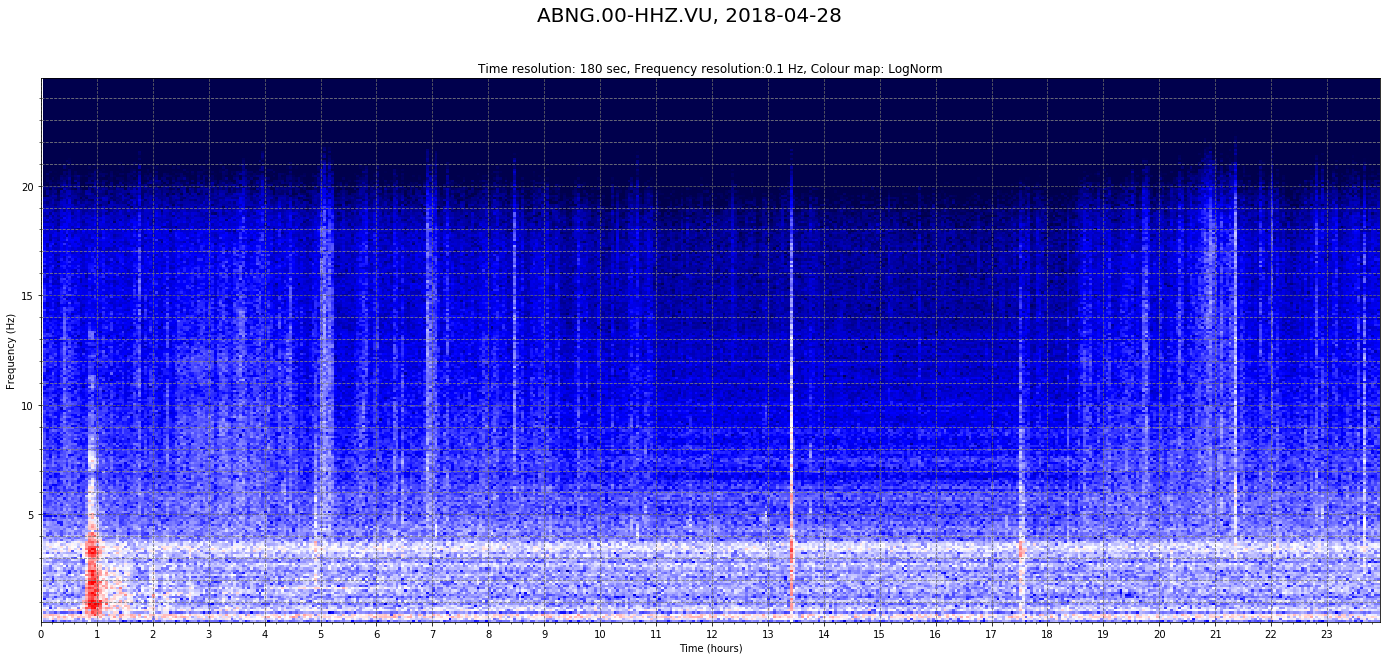

In [8]:
fig,ax = plt.subplots(figsize=(24,10))
ax.pcolormesh(hour, f, z, cmap='seismic', norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))

ax.set_ylim(f.min(), f.max())
ax.set_xlim(hour.min(), hour.max())
ax.set_xticks(np.arange(hour.min(), hour.max(), 1))
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (hours)')
ax.grid(b=True, which='major', color='dimgray', linestyle='--', linewidth=0.75)
ax.grid(b=True, which='minor', color='gray', linestyle='--', axis='y')
ax.minorticks_on()

suptitle = sta+'.'+loc+'-'+cmp+'.'+net+', '+date
title = 'Time resolution: '+str(win)+' sec, Frequency resolution:'+str(fint)+' Hz, Colour map: LogNorm'
plt.suptitle(suptitle, fontsize=20)
plt.title(title, fontsize=12);

pfile = sta+'.'+loc+'-'+cmp+'.'+net+'_'+date+'.png'
plt.savefig(pfile, dpi=200)